In [1]:
import pandas as pd
import json
import numpy as np
from nltk import sent_tokenize
from tqdm import tqdm
from src import Helpers
import pickle

# Preprocessing

## Step 1 : Load the datasets

### US movies dataset

In [72]:
CHARACTER_DATA_PATH = './data/character.metadata.tsv'
MOVIE_DATA_PATH = './data/movie.metadata.tsv'
SUMMARIES_DATA_PATH = './data/plot_summaries.txt'
NAME_DATA_PATH = './data/name.clusters.txt'
TYPE_DATA_PATH = './data/tvtropes.clusters.txt'

In [73]:
MOVIE_HEADER = ['Wikipedia_movie_ID','Freebase_movie_ID','Movie_name','Movie_release_date',
                'Movie_box_office_revenue','Movie_runtime','Movie_languages','Movie_countries','Movie_genres']

movies = pd.read_table(MOVIE_DATA_PATH,header=None,names=MOVIE_HEADER)

In [74]:
len(movies)

81741

In [75]:
def format_dict(x):
    n = len(x)
    if n==0:
        return np.nan
    else:
        return ','.join(str(s) for s in list(x.values()))
    

try :

    movies['Movie_genres'] = movies['Movie_genres'].apply(json.loads).apply(format_dict)
    movies['Movie_countries'] = movies['Movie_countries'].apply(json.loads).apply(format_dict)
    movies['Movie_languages'] = movies['Movie_languages'].apply(json.loads).apply(format_dict)
except json.decoder.JSONDecodeError:
    print('Data has already been parsed and modified.')
    
# Keep only American movies
us_movies = movies[movies['Movie_countries'].astype(str).str.contains('United States of America')]
print("Number of US movies : {}".format(len(us_movies)))

Number of US movies : 34408


In [76]:
display(us_movies)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,English Language,United States of America,"Thriller,Science Fiction,Horror,Adventure,Supe..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,English Language,United States of America,"Mystery,Biographical film,Drama,Crime Drama"
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"Silent film,English Language",United States of America,"Short Film,Silent film,Indie,Black-and-white,C..."
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,English Language,United States of America,"Musical,Comedy,Black-and-white"
10,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,English Language,United States of America,"Drama,Black-and-white"
...,...,...,...,...,...,...,...,...,...
81725,1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"Italian Language,English Language","France,United States of America","Parody,Americana,Comedy"
81726,664006,/m/030xw6,Guilty as Sin,1993-06-04,22886222.0,107.0,NaN,United States of America,"Thriller,Erotic thriller,Psychological thrille..."
81727,24209227,/m/07k5mlk,"The Time, the Place and the Girl",1946,NaN,105.0,English Language,United States of America,"Comedy film,Romance Film,Musical"
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,English Language,United States of America,Drama


### Summaries dataset

In [77]:
summaries = pd.read_table(SUMMARIES_DATA_PATH,header=None,names=['Wikipedia_movie_ID','Summary'])
summaries.dropna(inplace=True)
display(summaries)

,Wikipedia_movie_ID,Summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...
...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se..."


### Character dataset

In [78]:
# Load character dataset
characters = Helpers.load_data("character.metadata.tsv")

# Change the names of certains columns
characters.rename(columns={'Wiki_movie_id': 'Wikipedia_movie_ID', 'Freebase character/actor map ID':'Fb_char_to_actor_ID'},
                  inplace=True)

# Drop rows where the name of the caracter played by the actor is unknown, or the name of the actor is unknown
characters.dropna(subset=['Character','Actor_name'],inplace=True,axis=0)

# Keep only characters related to US movies that have a synopsis
characters = characters[characters['Wikipedia_movie_ID'].isin(us_movies.Wikipedia_movie_ID.unique()) &
                        characters['Wikipedia_movie_ID'].isin(summaries.Wikipedia_movie_ID.unique())]

# Add name of the movie in which the character was present (will be useful later)
tmp_dico = dict(zip(us_movies.Wikipedia_movie_ID, us_movies.Movie_name))
characters['Movie_name'] = characters.Wikipedia_movie_ID.apply(lambda x : tmp_dico[x])

# Important when using iterrows() (see later) : reset_index
characters.reset_index(drop=True, inplace=True)

In [79]:
display(characters)

,Wikipedia_movie_ID,Fb_movie_id,release_date,Character,Actor date of birth,Actor gender,Actor_height,Fb_actor_ethnicity_id,Actor_name,Actor_age,Fb_char_to_actor_ID,Fb_char_id,Fb_actor_id,Movie_name
0,975900,03vyhn,2001.0,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,0bgchxw,0bgcj3x,03wcfv7,Ghosts of Mars
1,975900,03vyhn,2001.0,Lieutenant Melanie Ballard,1974-08-15,F,1.780,044038p,Natasha Henstridge,27.0,0jys3m,0bgchn4,0346l4,Ghosts of Mars
2,975900,03vyhn,2001.0,Desolation Williams,1969-06-15,M,1.727,0x67,Ice Cube,32.0,0jys3g,0bgchn_,01vw26l,Ghosts of Mars
3,975900,03vyhn,2001.0,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,02vchl6,0bgchnq,034hyc,Ghosts of Mars
4,975900,03vyhn,2001.0,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,02vbb3r,0bgchp9,01y9xg,Ghosts of Mars
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93618,30553937,0g9ts5h,1998.0,Steve,1959-04-02,M,NaN,NaN,Steve Monarque,38.0,0jxtp_5,0jxtp_8,0bl1p7,Confessions of a Sexist Pig
93619,30553937,0g9ts5h,1998.0,Mark,NaN,M,NaN,NaN,Kevin Richardson,NaN,0jxtpzm,0jxtpzq,0jxtpzy,Confessions of a Sexist Pig
93620,30553937,0g9ts5h,1998.0,Barbara,NaN,F,NaN,NaN,Leda Mulholland,NaN,0jxtsvw,0jxtsvz,0gbyr6p,Confessions of a Sexist Pig
93621,30553937,0g9ts5h,1998.0,Restaurant Manager,NaN,M,NaN,NaN,Randy Harris,NaN,0jxtsx5,0jxtsx8,0jxtsxh,Confessions of a Sexist Pig


We have 93623 characters related to US movies for which we have a synopsis

Before moving further, let's check that 'Fb_char_to_actor_ID' is truly unique in this dataframe : we will use it as primary key later.

In [80]:
nb = (characters.Fb_char_to_actor_ID.value_counts() > 1).sum()
print(str(nb)+'\nOK !')

0
OK !


### CharType dataset (tvtropes)

In [81]:
# Load the 'tvtropes' dataset, thereafter called 'chartypes'
chartypes = Helpers.load_data("tvtropes.clusters.txt")
# Rename certains columns for coherence with other dataframes
chartypes.rename(columns={'Char':'Character', 'Movie':'Movie_name', 'Actor':'Actor_name', 'Fb_char_actor_id':'Fb_char_to_actor_ID'}, inplace=True)
display(chartypes)

,CharType,Character,Movie_name,Fb_char_to_actor_ID,Actor_name
0,absent_minded_professor,Professor Philip Brainard,Flubber,0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,0k3rhh,James Spader
...,...,...,...,...,...
496,young_gun,Morgan Earp,Tombstone,0k776f,Bill Paxton
497,young_gun,Colorado Ryan,Rio Bravo,0k2kqg,Ricky Nelson
498,young_gun,Tom Sawyer,The League of Extraordinary Gentlemen,0k5nsh,Shane West
499,young_gun,William H. 'Billy the Kid' Bonney,Young Guns II,03lrjk0,Emilio Estevez


Unfortunately, we only have 501 characters which were given a character type (CharType) !

In [82]:
len(chartypes.CharType.unique())

72

Besides, we have 72 characters types : this is way too high, given the small amount of characterized characters we have. 

Let's reduce it. To do so, we asked ChatGPT to cluster our 72 CharTypes into only 7 main CharTypes, with an evenly distribution. We obtained the following mapping : 

In [83]:
chartype_mapping = {
    'absent_minded_professor': 'Complex Personalities',
    'adventurer_archaeologist': 'Adventurers and Heroes',
    'arrogant_kungfu_guy': 'Complex Personalities',
    'big_man_on_campus': 'Stereotypes and Tropes',
    'bounty_hunter': 'Occupation and Professions',
    'brainless_beauty': 'Stereotypes and Tropes',
    'broken_bird': 'Moral Ambiguity and Antagonists',
    'bromantic_foil': 'Everyday Characters and Tropes',
    'bruiser_with_a_soft_center': 'Everyday Characters and Tropes',
    'bully': 'Stereotypes and Tropes',
    'byronic_hero': 'Complex Personalities',
    'casanova': 'Stereotypes and Tropes',
    'chanteuse': 'Complex Personalities',
    'charmer': 'Everyday Characters and Tropes',
    'child_prodigy': 'Adventurers and Heroes',
    'classy_cat_burglar': 'Stereotypes and Tropes',
    'consummate_professional': 'Adventurers and Heroes',
    'corrupt_corporate_executive': 'Moral Ambiguity and Antagonists',
    'coward': 'Moral Ambiguity and Antagonists',
    'crazy_jealous_guy': 'Emotional and Romantic Tropes',
    'crazy_survivalist': 'Complex Personalities',
    'cultured_badass': 'Adventurers and Heroes',
    'dean_bitterman': 'Everyday Characters and Tropes',
    'dirty_cop': 'Moral Ambiguity and Antagonists',
    'ditz': 'Stereotypes and Tropes',
    'doormat': 'Everyday Characters and Tropes',
    'drill_sargeant_nasty': 'Occupation and Professions',
    'dumb_blonde': 'Stereotypes and Tropes',
    'dumb_muscle': 'Stereotypes and Tropes',
    'eccentric_mentor': 'Complex Personalities',
    'egomaniac_hunter': 'Moral Ambiguity and Antagonists',
    'evil_prince': 'Moral Ambiguity and Antagonists',
    'fastest_gun_in_the_west': 'Adventurers and Heroes',
    'father_to_his_men': 'Occupation and Professions',
    'final_girl': 'Occupation and Professions',
    'gadgeteer_genius': 'Adventurers and Heroes',
    'gentleman_thief': 'Everyday Characters and Tropes',
    'granola_person': 'Complex Personalities',
    'grumpy_old_man': 'Everyday Characters and Tropes',
    'hardboiled_detective': 'Emotional and Romantic Tropes',
    'heartbroken_badass': 'Emotional and Romantic Tropes',
    'henpecked_husband': 'Everyday Characters and Tropes',
    'hitman_with_a_heart': 'Emotional and Romantic Tropes',
    'jerk_jock': 'Everyday Characters and Tropes',
    'junkie_prophet': 'Complex Personalities',
    'klutz': 'Everyday Characters and Tropes',
    'loser_protagonist': 'Everyday Characters and Tropes',
    'loveable_rogue': 'Everyday Characters and Tropes',
    'master_swordsman': 'Adventurers and Heroes',
    'morally_bankrupt_banker': 'Occupation and Professions',
    'officer_and_a_gentleman': 'Occupation and Professions',
    'ophelia': 'Emotional and Romantic Tropes',
    'playful_hacker': 'Occupation and Professions',
    'prima_donna': 'Emotional and Romantic Tropes',
    'psycho_for_hire': 'Moral Ambiguity and Antagonists',
    'pupil_turned_to_evil': 'Moral Ambiguity and Antagonists',
    'retired_outlaw': 'Occupation and Professions',
    'revenge': 'Emotional and Romantic Tropes',
    'romantic_runnerup': 'Emotional and Romantic Tropes',
    'self_made_man': 'Occupation and Professions',
    'slacker': 'Everyday Characters and Tropes',
    'stoner': 'Everyday Characters and Tropes',
    'storyteller': 'Complex Personalities',
    'stupid_crooks': 'Everyday Characters and Tropes',
    'surfer_dude': 'Occupation and Professions',
    'the_chief': 'Occupation and Professions',
    'the_editor': 'Occupation and Professions',
    'tranquil_fury': 'Emotional and Romantic Tropes',
    'trickster': 'Occupation and Professions',
    'valley_girl': 'Stereotypes and Tropes',
    'warrior_poet': 'Adventurers and Heroes',
    'young_gun': 'Occupation and Professions'
}

Now, we create a new column in `chartypes` called 'MainCharType', based on this mapping

In [84]:
chartypes['MainCharType'] = chartypes['CharType'].map(chartype_mapping)

chartypes.sample(3)

,CharType,Character,Movie_name,Fb_char_to_actor_ID,Actor_name,MainCharType
342,loveable_rogue,Abu,The Thief of Bagdad,0k6nkk,Sabu Dastagir,Everyday Characters and Tropes
321,jerk_jock,Gaston,Beauty and the Beast,0jv4jc,Richard White,Everyday Characters and Tropes
201,dumb_blonde,Cindy Campbell,Scary Movie 4,0k2y_7,Anna Faris,Stereotypes and Tropes


Again, let's check for the unicity of 'Fb_char_to_actor_ID' in this dataframe...

In [85]:
chartypes.Fb_char_to_actor_ID.value_counts()

Fb_char_to_actor_ID
0k1xxm     5
02hw79s    4
0j_fvv     3
0j1__hv    3
0k65z5     3
          ..
0k79b3     1
0k60j5     1
0jx21w     1
0jy52w     1
0k39jj     1
Name: count, Length: 447, dtype: int64

**Unfortunately, it is not unique !**
As one can see above, some IDs correspond to multiple entries in the dataframe. Why ?

In [86]:
chartypes[chartypes.Fb_char_to_actor_ID == '0k1xxm']

,CharType,Character,Movie_name,Fb_char_to_actor_ID,Actor_name,MainCharType
73,byronic_hero,Captain Jack Sparrow,Pirates of the Caribbean: Dead Man's Chest,0k1xxm,Johnny Depp,Complex Personalities
95,charmer,Captain Jack Sparrow,Pirates of the Caribbean: Dead Man's Chest,0k1xxm,Johnny Depp,Everyday Characters and Tropes
132,coward,Captain Jack Sparrow,Pirates of the Caribbean: Dead Man's Chest,0k1xxm,Johnny Depp,Moral Ambiguity and Antagonists
339,loveable_rogue,Captain Jack Sparrow,Pirates of the Caribbean: Dead Man's Chest,0k1xxm,Johnny Depp,Everyday Characters and Tropes
476,trickster,Captain Jack Sparrow,Pirates of the Caribbean: Dead Man's Chest,0k1xxm,Johnny Depp,Occupation and Professions


Because some characters have been given multiple character types, called 'CharType' ! 

To solve this, we keep only one entry, corresponding to the predominant 'MainCharType'. Note that sometimes, multiples 'CharType' could still have the same 'MainCharType'

Besides, if two 'MainCharType' have the same importance (ex : 'Antiheroes' and 'Lovers and Romantics' for Captain Jack Sparrow), then we use the following *priority list* to break the tie : the idea is to try to have an equal presence between the 12 'MainCharType' in the dataframe

In [87]:
# The priority list to choose, if needed, between two 'MainCharType'
priority_list = chartypes.MainCharType.value_counts().sort_values().index.tolist()
priority_list

['Adventurers and Heroes',
 'Stereotypes and Tropes',
 'Complex Personalities',
 'Moral Ambiguity and Antagonists',
 'Emotional and Romantic Tropes',
 'Occupation and Professions',
 'Everyday Characters and Tropes']

In [88]:
# Get a list of the IDs that are problematic
nb = (chartypes.Fb_char_to_actor_ID.value_counts() > 1).sum()
conflicting_ids = (chartypes.Fb_char_to_actor_ID.value_counts() > 1).index[:nb]

In [89]:
def get_MainCharType(ID):
    """
    Input - ID : the 'Fb_char_to_actor_ID' of a character which has multiple entries in the 'chartypes' dataset
    Output - The most relevant MainCharType for this character
    """
    # Get the entries of the problematic ID, which was assigned at least two different CharType
    small_df = chartypes[chartypes.Fb_char_to_actor_ID == ID].copy()
    # Get the number of time each MainCharType appears for this character, sorted in decreasing order
    sorted_values = small_df.MainCharType.value_counts().tolist()
    sorted_types = small_df.MainCharType.value_counts().keys().tolist()
    # Special case : only one MainCharType
    if len(sorted_values) == 1:
        return(sorted_types[0])
    # Special case : if we detect a tie
    if sorted_values[0] == sorted_values[1]:
        # Get all the contenders of the tie (could be more than 2)
        contenders = sorted_types[:2]
        for i in range(2,len(sorted_values)):
            if sorted_values[i] == sorted_values[0]:
                contenders.append(sorted_types[i])
        # Break the tie using the priority list between MainCharTypes
        for e in priority_list:
            if e in contenders:
                return(e)
    # Default case : the MainCharType with the highest number of appearance wins
    return(sorted_types[0])  

In [90]:
# At last ! Get the MainCharType for each conflicting character
tmp_dico = {}
for ID in conflicting_ids:
    tmp_dico[ID] = get_MainCharType(ID)

# Drop duplicates in the dataframe
chartypes.drop_duplicates(subset=['Fb_char_to_actor_ID'],keep='first',inplace=True)

# Assign the proper MainCharType for each conflicting character in the dataframe
for ID in conflicting_ids:
    chartypes[chartypes.Fb_char_to_actor_ID == ID]['MainCharType'] = tmp_dico[ID]

C:\Users\beynes\AppData\Local\Temp\ipykernel_19724\1547837368.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chartypes[chartypes.Fb_char_to_actor_ID == ID]['MainCharType'] = tmp_dico[ID]


Has it work ?

In [91]:
(chartypes.Fb_char_to_actor_ID.value_counts() > 1).sum()

0

In [92]:
print('Yes !')

Yes !


In [93]:
display(chartypes)

,CharType,Character,Movie_name,Fb_char_to_actor_ID,Actor_name,MainCharType
0,absent_minded_professor,Professor Philip Brainard,Flubber,0jy9q0,Robin Williams,Complex Personalities
1,absent_minded_professor,Professor Keenbean,Richie Rich,02vchl3,Michael McShane,Complex Personalities
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,0k6fkc,Ian McKellen,Complex Personalities
3,absent_minded_professor,Dr. Harold Medford,Them!,0k6_br,Edmund Gwenn,Complex Personalities
4,absent_minded_professor,Daniel Jackson,Stargate,0k3rhh,James Spader,Complex Personalities
...,...,...,...,...,...,...
496,young_gun,Morgan Earp,Tombstone,0k776f,Bill Paxton,Occupation and Professions
497,young_gun,Colorado Ryan,Rio Bravo,0k2kqg,Ricky Nelson,Occupation and Professions
498,young_gun,Tom Sawyer,The League of Extraordinary Gentlemen,0k5nsh,Shane West,Occupation and Professions
499,young_gun,William H. 'Billy the Kid' Bonney,Young Guns II,03lrjk0,Emilio Estevez,Occupation and Professions


## Step 2 : merge `chartypes` and `characters`

Finally, we perform an outer join between `characters` and `chartypes` : when 'MainCharType' is unknown, it is filled with NaN. 

In [94]:
full_characters = chartypes.merge(characters, how='outer', on=['Fb_char_to_actor_ID','Character','Actor_name','Movie_name'])

In [95]:
full_characters.sample(5)

,CharType,Character,Movie_name,Fb_char_to_actor_ID,Actor_name,MainCharType,Wikipedia_movie_ID,Fb_movie_id,release_date,Actor date of birth,Actor gender,Actor_height,Fb_actor_ethnicity_id,Actor_age,Fb_char_id,Fb_actor_id
86242,NaN,Abigail Delorean,The Walker,03l0qrv,Lily Tomlin,NaN,12286771.0,02vz055,2007.0,1939-09-01,F,1.73,NaN,68.0,0h2y_tk,011_3s
3435,NaN,Carrie,Play the Game,0gcxk1w,Juliette Jeffers,NaN,19583175.0,04n3lf7,2009.0,NaN,F,NaN,NaN,NaN,0n4mbqw,0gcxk1y
25450,NaN,Hotel Heavy,Cloud Atlas,0n9zv1n,Hugh Grant,NaN,31232694.0,0gh65c5,2012.0,1960-09-09,M,1.80,0d7wh,51.0,0n9zv1r,016xh5
23284,NaN,Miriam Ellis,Mildred Pierce,0h5p7cx,Veda Ann Borg,NaN,4995581.0,0cy__l,1945.0,1915-01-11,F,NaN,NaN,30.0,0h5p7c_,027_9ky
62218,NaN,Babu,Kama Sutra: A Tale of Love,0h5nhgn,Ranjit Chowdhry,NaN,852742.0,03h8rg,1996.0,NaN,M,NaN,NaN,NaN,0h5nhgr,0ggw8w


Does each character appear only once in this merged dataframe ? Yes ! 

In [96]:
(full_characters.Fb_char_to_actor_ID.value_counts() > 1).sum()

0

In [97]:
print("We have {} characters with unknown MainCharType".format(len(full_characters[full_characters.MainCharType.isnull()])))


We have 93201 characters with unknown MainCharType


In [98]:
print("And {} characters for which MainCharType is known".format(len(full_characters[full_characters.MainCharType.notna()])))


And 447 characters for which MainCharType is known


# Main analysis

Here comes the main question : 

**We have about 93k characters in `full_characters`, of which only about 450 have a 'MainCharType'. How can we assign a 'MainCharType' to those that do not have one ?**

By using NLP techniques...

But first, let's make sure that we do a movie synopsis for each entry of the `full_characters` dataset

In [99]:
# Number of entries before modification
before = len(full_characters)
# Keep only entries that have a synopsis in "summaries"
full_characters = full_characters[full_characters.Wikipedia_movie_ID.isin(summaries.Wikipedia_movie_ID.unique())]
# Number of entries after modification
after = len(full_characters)

print("By keeping only entries associated with a movie synopsis, we have lost {} entries".format(before-after))

By keeping only entries associated with a movie synopsis, we have lost 25 entries


In [100]:
print("And we now have {} characters with known MainCharType and that are associated to a movie synopsis".format(
            len(full_characters[full_characters.MainCharType.notna()])))

And we now have 422 characters with known MainCharType and that are associated to a movie synopsis


## Step 1 : Retrieve synopsis sentences related to each character in `full_characters`

For each entry/character in the dataframe, we want to get the sentences of the synopsis (of the movie in which the character appears) in which the character's name is mentionned.

To achieve the greatest possible retrieval rate, we must test multiple cases in each synopsis' sentence :
- Search for the entire character's name
- Search for the name of the actor who played the character
- Search for parts of the character's name (i.e. first name and last name)

In this last case, multiple subcases must be consider to avoir errors : 
- We don't want to search for linking workds (ex : 'de' in 'Jack de Rose')
- We don't want to search for function nouns, since they are generic and could refer to another character (ex : 'Doctor','Captain','Lieutenant'...)

How to do this ? We try to establish a `dont_search_for` set of function nouns present in the dataset, by assuming that the function noun will always be placed first in a character's name. 

Besides, we restrict ourselves to character names of at least 3 words for two reasons. First, if the first word gets unwanted, we still have a word to search for in the synopsis. Second, the higher the number of words in a character name, the more likely the first word is to be a function noun.

On top of that, we delete all the words of the `dont_search_for` set that belongs to the dataset 'babynames_clean', a CSV file of about 7000 common names that we downloaded from 'https://data.world/alexandra/baby-names'

In [101]:
# Load the dataset of common names and make it a set
common_names = set(pd.read_csv('babynames-clean.csv', sep=',', header=None, names=['Name','Gender'])['Name'].unique())
common_names

{'Celeste',
 'Greg',
 'Angelina',
 'Kieran',
 'Wong',
 'Vern',
 'Orlo',
 'Elaine',
 'Maryann',
 'Ula',
 'Johanna',
 'Marlyn',
 'Rhea',
 'Rosabelle',
 'Khloe',
 'Shanon',
 'Sadie',
 'Elon',
 'Kobe',
 'Fronnie',
 'Biddie',
 'Benjman',
 'Forest',
 'Garey',
 'Shianne',
 'Janiyah',
 'Alfie',
 'Shatara',
 'Keyon',
 'Queenie',
 'Enriqueta',
 'Velia',
 'Arra',
 'Taliyah',
 'Obe',
 'Kate',
 'Tod',
 'Kristy',
 'Doc',
 'Wilton',
 'Claudine',
 'Etta',
 'Edison',
 'Masao',
 'Sabastian',
 'Cleo',
 'Erle',
 'Kazuo',
 'Tonya',
 'Erasmo',
 'Eben',
 'Chaz',
 'Adron',
 'Destiny',
 'Ivah',
 'Pamelia',
 'Cristofer',
 'Cleve',
 'Luanne',
 'Corinna',
 'Waneta',
 'Teri',
 'Ridge',
 'Erving',
 'Rodney',
 'Louvenia',
 'Avie',
 'Loni',
 'Davon',
 'Elberta',
 'Arden',
 'Ashlynn',
 'Sammie',
 'Maritza',
 'Edmund',
 'Sherilyn',
 'Adriel',
 'Celestino',
 'Helena',
 'Bea',
 'Suzette',
 'Jordon',
 'Volney',
 'Alexandra',
 'Marrion',
 'Sylvanus',
 'Tilman',
 'Kori',
 'Erma',
 'Kadence',
 'Dax',
 'Danny',
 'Harrold',
 '

In [102]:
# Create the set of words we should not search for
dont_search_for = set()
# We can already add some words
dont_search_for.update(['de','Captain'])

for _, entry in full_characters.iterrows():
    # Split the character's name into multiple strings, using ' ' as a separator
    split_name = entry['Character'].split()
    # Get the first word
    potential_noun = split_name[0]
    # If it a string of the form " Alicia's ", we want to remove " 's " at the end in order to detect that it is a name
    test_name = potential_noun.removesuffix("'s")
    # But it could be not a name : "client's" becomes "client", and "client" is not a name. 
    # So we test if it belongs to common_names
    if len(split_name) >= 3 and test_name not in common_names:
        # Add the original word if not already present
        if potential_noun not in dont_search_for:
            dont_search_for.add(potential_noun)

In [103]:
sorted(dont_search_for)

["'2-Gun'",
 "'A'",
 "'Ayatollah",
 "'Baby",
 "'Badge",
 "'Bluebeard',-",
 "'Buttons'",
 "'Captain'",
 "'Cousin'",
 "'Damian',",
 "'Dearest'",
 "'Dice-man'",
 "'Fat'",
 "'Helix'",
 "'Horny'",
 "'Hot",
 "'Joliet'",
 "'Jose'",
 "'Juicy'",
 "'Jumpin'",
 "'Kit",
 "'Klownzilla'",
 "'Little",
 "'Little'",
 "'MILF'",
 "'Michael",
 "'Nuff",
 "'Og'",
 "'Reverend'",
 "'Ronald",
 "'Smilin'",
 "'The",
 "'Time",
 "'Tip'",
 "'Too",
 "'Uncle",
 "'Uncle'",
 "'Wacky'",
 "'Wild",
 "'Wild'",
 '....',
 '01',
 '16',
 '17',
 '1931',
 '1978',
 '1st',
 '2nd',
 '3rd',
 '4th',
 '5',
 '5th',
 '6',
 '7-Year-Old',
 '9',
 'A',
 'A.',
 'A.C.,',
 'A.J.',
 'A.R.',
 'A.T.F.',
 'ACWO',
 'ADA',
 'Aardvark',
 'Abernathy',
 'Abhimanyu',
 'Above',
 'Academy',
 'Ace,',
 'Acme',
 'Actor',
 'Actress',
 'Actress/Breast',
 'Additional',
 'Adm.',
 'Admissions',
 'Adult',
 'Advisor',
 'Afghan',
 'Agathon',
 'Aged',
 'Agent',
 'Aging',
 'Aide',
 'Air',
 'Airbag',
 'Airman',
 'Airplane',
 'Airport',
 "Aislinn's",
 'Akiro',
 'Al,',
 

The result is not perfect, but we still have managed to detect many nouns in character names

Now, we use this to assign to each character in the `full_characters` the sentences of the movie synopsis where it is mentionned.

### Make it again in lowercase !

In [104]:
total_related_sent = []
total_related_sent_indices = []

for _, entry in tqdm(full_characters.iterrows(), total=full_characters.shape[0]):
    related_sent = []
    related_sent_indices = []
    # Get character name
    name = entry['Character']
    # Split it into substrings
    split_name = name.split()
    # Get related synopsis
    synopsis = summaries.loc[summaries.Wikipedia_movie_ID == entry.Wikipedia_movie_ID, 'Summary'].values[0]
    # Clean and split the synopsis into sentences
    synopsis = synopsis.replace(u'\xa0', u' ')
    synopsis = synopsis.replace(u'\xc2','')
    sentences = sent_tokenize(synopsis)
    # Search for sentences containing the name of the character
    for i in range(len(sentences)):
        sentence = sentences[i]
        # First, we search for the full characer's name or actor's name
        if name in sentence or entry['Actor_name'] in sentence:
            related_sent.append(sentence)
            related_sent_indices.append(i)
        # If this has not worked, we search for words in the character's name, while being cautious ('dont_search_for' set)
        else:
            for word in split_name:
                if word not in dont_search_for and word in sentence:
                    # Check before that we don't add a duplicate
                    if i not in related_sent_indices:
                        related_sent.append(sentence)
                        related_sent_indices.append(i)
    # Save the results 
    if len(related_sent) != 0:
        total_related_sent.append(related_sent)
        total_related_sent_indices.append(related_sent_indices)
    else:
        total_related_sent.append(np.nan)
        total_related_sent_indices.append(np.nan)

        
full_characters['related_sent'] = total_related_sent
full_characters['related_sent_indices'] = total_related_sent_indices

100%|██████████████████████████████████████████████████████████████████████████| 93623/93623 [01:21<00:00, 1148.10it/s]


In [105]:
display(full_characters)

,CharType,Character,Movie_name,Fb_char_to_actor_ID,Actor_name,MainCharType,Wikipedia_movie_ID,Fb_movie_id,release_date,Actor date of birth,Actor gender,Actor_height,Fb_actor_ethnicity_id,Actor_age,Fb_char_id,Fb_actor_id,related_sent,related_sent_indices
0,absent_minded_professor,Professor Philip Brainard,Flubber,0jy9q0,Robin Williams,Complex Personalities,1344253.0,04vcfx,1997.0,1951-07-21,M,1.702,NaN,46.0,0cls20k,0dzf_,"[Professor Philip Brainard , a professor at Me...","[0, 2, 4, 5, 6, 8, 9, 10, 11, 14, 16, 19, 20, ..."
1,absent_minded_professor,Professor Keenbean,Richie Rich,02vchl3,Michael McShane,Complex Personalities,1486573.0,0557n3,1994.0,1955-06-25,M,NaN,NaN,39.0,0h6dygh,05tkfc,"[He even had the Rich family's head scientist,...","[8, 13, 21, 22, 28, 30, 34, 37, 38, 43, 44]"
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,0k6fkc,Ian McKellen,Complex Personalities,5991505.0,0fjjjh,1994.0,1939-05-25,M,1.800,NaN,55.0,0gynqd6,03ym1,[The Shadow's secret is endangered when Cranst...,"[13, 19, 20, 22, 23, 26, 29, 30]"
3,absent_minded_professor,Dr. Harold Medford,Them!,0k6_br,Edmund Gwenn,Complex Personalities,605676.0,02vt5c,1954.0,1877-09-26,M,NaN,NaN,NaN,0h5whpq,03bpcj,[There was enough formic acid in his body to k...,"[15, 16, 19, 23, 24, 27, 48]"
4,absent_minded_professor,Daniel Jackson,Stargate,0k3rhh,James Spader,Complex Personalities,28327.0,070g7,1994.0,1960-02-07,M,1.780,NaN,34.0,02qs1z,043js,"[In the present day, Langford's daughter Cathe...","[1, 2, 3, 6, 8, 10, 11, 12, 14, 15, 22, 28, 29..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93643,NaN,Steve,Confessions of a Sexist Pig,0jxtp_5,Steve Monarque,NaN,30553937.0,0g9ts5h,1998.0,1959-04-02,M,NaN,NaN,38.0,0jxtp_8,0bl1p7,NaN,NaN
93644,NaN,Mark,Confessions of a Sexist Pig,0jxtpzm,Kevin Richardson,NaN,30553937.0,0g9ts5h,1998.0,NaN,M,NaN,NaN,NaN,0jxtpzq,0jxtpzy,NaN,NaN
93645,NaN,Barbara,Confessions of a Sexist Pig,0jxtsvw,Leda Mulholland,NaN,30553937.0,0g9ts5h,1998.0,NaN,F,NaN,NaN,NaN,0jxtsvz,0gbyr6p,NaN,NaN
93646,NaN,Restaurant Manager,Confessions of a Sexist Pig,0jxtsx5,Randy Harris,NaN,30553937.0,0g9ts5h,1998.0,NaN,M,NaN,NaN,NaN,0jxtsx8,0jxtsxh,NaN,NaN


In [106]:
percentage = len(full_characters[full_characters.related_sent_indices.notna()]) / len(full_characters)
print("Percentage of characters in the dataframe that could be associated with synopsis sentences : {:2.2%}".format(percentage))

Percentage of characters in the dataframe that could be associated with synopsis sentences : 53.01%


That's quite satisfying : we should be able to classify the MainCharType for more than half the characters of the database !

In [107]:
# We keep only entries for which related synopsis sentences could be retrieved
full_characters.dropna(subset=['related_sent'],inplace=True)

Let's check the average number of sentences for each entry (i.e. character) in the dataframe :

In [108]:
nb = sum([len(full_characters.iloc[i]['related_sent']) for i in range(len(full_characters))]) / len(full_characters)
print("Average number of sentences per character : {:.2}".format(nb))

Average number of sentences per character : 6.7


It seems large enough to have a good characterization of each character !

### Step 1.5 : complete `full_characters` with embeddings of corresponding sentences

In another script, we have calculated embeddings for every sentence of every synopsis, by using sentence transformer model ('all-MiniLM-L6-v2', based on BERT model). Let's load it :

In [109]:
# Load the embeddings of the sentences of every synopsis
with open('all_embeddings.pickle', 'rb') as handle:
    all_embeddings = pickle.load(handle)

**all_embeddings** is a dictionnary : each key is a **Wikipedia_movie_ID**, and contains the following tuple : 

**(mean_vector, all_vectors)** = (mean of all sentence embeddings, list of the embeddings of all the sentences in the synopsis)

Now, we add to each entry of `full_characters` the embeddings corresponding to the sentences related to this entry/character

In [110]:
total_related_embeddings = []

# For each entry/character of the dataframe
for _, entry in tqdm(full_characters.iterrows(), total=full_characters.shape[0]):
    related_embeddings = []
    # Get all the embeddings for the synopsis of the movie in which the character appears
    embeddings_of_synopsis = all_embeddings[entry.Wikipedia_movie_ID][1]
    # Keep only the embeddings of sentences that mention the character
    for index in entry.related_sent_indices:
        related_embeddings.append(embeddings_of_synopsis[index])
    # Store the result
    total_related_embeddings.append(related_embeddings)

full_characters['related_embeddings'] = total_related_embeddings

100%|█████████████████████████████████████████████████████████████████████████| 49629/49629 [00:03<00:00, 13320.42it/s]


For instance, for Captain Jack Sparrow in *Pirates of the Caribbean: Dead Man's Chest* (ID 0k1xxm), we get the following related sentences, and their corresponding embeddings :

In [111]:
full_characters[full_characters.Fb_char_to_actor_ID == '0k1xxm']['related_sent'].values

array([list([' On their wedding day Will Turner and Elizabeth Swann are confronted by Lord Cutler Beckett, head of the East India Trading Company, with arrest warrants for their helping pirate Captain Jack Sparrow escape execution.', 'Former Commodore Norrington is also wanted for delaying the pursuit of Sparrow, but Norrington has resigned from the British Royal Navy months prior and disappeared.', "Beckett sends Will to recover Jack's compass in exchange for letters of marque that will make Sparrow a British privateer, and he promises Will and Elizabeth pardons.", "Will's father Bootstrap Bill Turner tells Jack he must keep his own promise to join the crew of Davy Jones, who raised the sunken Black Pearl for him years ago.", 'When Jack refuses, Bootstrap tells him Davy\'s "pet" will drag him to Davy Jones\' Locker.', 'Will finds the Black Pearl at Pelegosto, where a cannibal tribe worships Jack as a god, planning to kill him to release him from his "human state".', "After a jungle ch

In [112]:
full_characters[full_characters.Fb_char_to_actor_ID == '0k1xxm']['related_embeddings'].values

array([list([array([-1.02143340e-01,  1.26641025e-04,  5.92070399e-03, -2.70770881e-02,
               2.81091481e-02,  4.94809784e-02,  6.44272342e-02, -8.73776749e-02,
               5.36105596e-02, -1.32116033e-02, -8.34304467e-02,  6.49585500e-02,
              -4.55500819e-02,  6.49644062e-03, -4.16487306e-02,  3.83720472e-02,
              -2.44273134e-02, -2.50329394e-02,  3.02963443e-02,  1.39223441e-01,
              -3.13934870e-02, -1.66718587e-02, -1.81097332e-02,  2.92597767e-02,
              -8.89931470e-02, -8.92117769e-02,  5.13707399e-02, -8.07738164e-04,
              -4.18717824e-02, -5.50634135e-03,  6.83386549e-02,  2.56668720e-02,
               1.63973775e-03,  1.01123244e-01, -6.20653667e-02, -2.59437189e-02,
               6.03881218e-02,  2.51825079e-02,  2.00404897e-02, -6.76899701e-02,
               1.26722939e-02,  3.44249867e-02,  3.45343165e-02,  4.25143465e-02,
               4.47375700e-02, -5.25767580e-02, -1.65469013e-02,  2.18846370e-02,
          

Let's save our results

In [113]:
full_characters.to_pickle('full_characters_v2') 

## Step 2 : design an ad-hoc model and validate it with Leave-one-out cross-validation

In [2]:
# Load the dataframe built during step 1
full_characters = pd.read_pickle('full_characters_v2')

In [3]:
# We split our dataframe in two parts : one with known MainCharTypes, one with unkown MainCharType
labeled = full_characters[full_characters.MainCharType.notna()].copy().reset_index(drop=True)
unlabeled = full_characters[full_characters.MainCharType.isnull()].copy().reset_index(drop=True)

Now, we perform a Leave-one-out cross validation : for each character with known MainCharType, we try to predict this MainCharType using our model using all the other labeled entries. Then we compute the accuracy of our model.

We can use this cross-validation to test different implementations of our model, and see which offers the best performance.

In [4]:
print("Making predictions at random would give an accuracy of 1/7 = {:2.2%} on average.\nBut the standard deviation around this value could be very large."
      .format(1/7))

Making predictions at random would give an accuracy of 1/7 = 14.29% on average.
But the standard deviation around this value could be very large.


In [5]:
nb_sent_per_type = labeled.groupby(['MainCharType']).related_sent_indices.sum().str.len()
nb_sent_per_type

MainCharType
Adventurers and Heroes              605
Complex Personalities               815
Emotional and Romantic Tropes      1046
Everyday Characters and Tropes     1067
Moral Ambiguity and Antagonists     703
Occupation and Professions          828
Stereotypes and Tropes              632
Name: related_sent_indices, dtype: int64

We observe than the distribution of labeled characters between the 7 MainCharTypes is far from being uniform : our data is imbalanced. 

Let's use the number of sentences per MainCharType to calculate weightings.

In [6]:
weights = {}
char_types = ['Adventurers and Heroes','Complex Personalities','Emotional and Romantic Tropes',
              'Everyday Characters and Tropes','Moral Ambiguity and Antagonists','Occupation and Professions',
              'Stereotypes and Tropes']

# Weight for each MainCharType is the inverse of the number of sentences related to it
for t in char_types:
    weights[t] = 1 / nb_sent_per_type[t]

# Normalize the weights
total = sum(weights.values())
for t in char_types:
    weights[t] = weights[t] / total

weights

{'Adventurers and Heroes': 0.18394905678457804,
 'Complex Personalities': 0.1365511403124782,
 'Emotional and Romantic Tropes': 0.10639500894327888,
 'Everyday Characters and Tropes': 0.10430101157888447,
 'Moral Ambiguity and Antagonists': 0.15830608727549036,
 'Occupation and Professions': 0.13440722144283782,
 'Stereotypes and Tropes': 0.1760904736624521}

We perform Leave-one-out cross-validation : 

In [13]:
def predict_type(unlabeled_entry, labeled_entries):
    
    # We keep the 3 closest neighboors (and not only 1) + Not weightings
    labeled_entries.reset_index(inplace=True,drop=True)
    votes_on_type = {'Adventurers and Heroes':0,'Complex Personalities':0,'Emotional and Romantic Tropes':0,
              'Everyday Characters and Tropes':0,'Moral Ambiguity and Antagonists':0,'Occupation and Professions':0,
              'Stereotypes and Tropes':0}
    
    for sent in unlabeled_entry['related_embeddings']:
        max_val_1 = -11 # Smaller than max_val_2
        max_val_2 = -10 # Smaller than max_val_3
        max_val_3 = -9 # Greater than max_val_1 and max_val_2
        # We keep this order between the three highest values at each instant
        for i in range(len(labeled_entries)): 
            labeled_sent = labeled_entries.at[i, 'related_embeddings']
            for s in labeled_sent:
                val = np.dot(sent,s)/(np.linalg.norm(sent)*np.linalg.norm(s))
                if val > max_val_3:
                    # val is greater than all three highest values
                    max_val_3 = val
                    max_type_3 = labeled_entries.at[i, 'MainCharType']
                elif val > max_val_2:
                    # val is smaller than max_val_3 but greater than max_val_2
                    max_val_2 = val
                    max_type_2 = labeled_entries.at[i, 'MainCharType']
                elif val > max_val_1:
                    # val is smaller than max_val_2 but greater than max_val_1
                    max_val_1 = val
                    max_type_1 = labeled_entries.at[i, 'MainCharType']
        votes_on_type[max_type_1] += max_val_1
        votes_on_type[max_type_2] += max_val_2
        votes_on_type[max_type_3] += max_val_3
    # Get the MainCharType with highest value
    mainchartype = max(votes_on_type, key=votes_on_type.get)
    
    return(mainchartype)

In [132]:
correct_predictions = 0

# To understand the distribution of errors
cross_tab = pd.DataFrame(index=char_types, columns=char_types).fillna(0)

for i,character in tqdm(labeled.iterrows(), total=labeled.shape[0]):
    tmp_labeled = labeled.drop(index=i)
    prediction = predict_type(character, tmp_labeled)
    correct_predictions += int(prediction == character['MainCharType'])
    cross_tab.at[character['MainCharType'], prediction] += 1
    
print("Accuracy of the model is {:2.2%}".format(correct_predictions / len(labeled)))

100%|████████████████████████████████████████████████████████████████████████████████| 418/418 [03:50<00:00,  1.82it/s]

Accuracy of the model is 29.43%


Best accuracy achieved yet !

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.7222222222222, 0.5, 'True')]

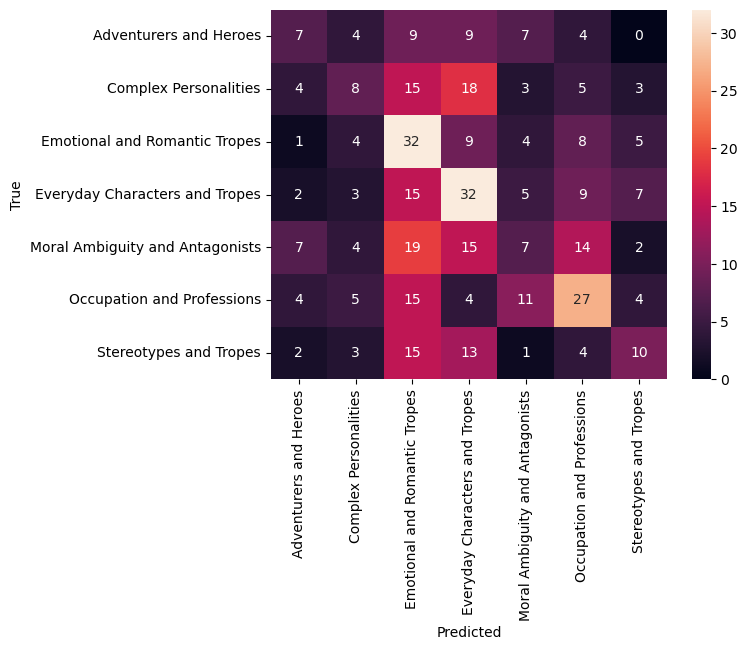

In [133]:
import seaborn as sns
ax = sns.heatmap(cross_tab, annot=True)
ax.set(xlabel="Predicted", ylabel="True")

In [134]:
accuracy_per_class = []

for i in range(len(cross_tab)):
    percentage = cross_tab.iat[i,i] / cross_tab.iloc[i].sum()
    accuracy_per_class.append(percentage)
    print("Accuracy for {} : {:2.2%}".format(cross_tab.index[i], percentage))
    
print("Mean accuracy over all class : {:2.2%}".format(sum(accuracy_per_class)/len(accuracy_per_class)))

Accuracy for Adventurers and Heroes : 17.50%
Accuracy for Complex Personalities : 14.29%
Accuracy for Emotional and Romantic Tropes : 50.79%
Accuracy for Everyday Characters and Tropes : 43.84%
Accuracy for Moral Ambiguity and Antagonists : 10.29%
Accuracy for Occupation and Professions : 38.57%
Accuracy for Stereotypes and Tropes : 20.83%
Mean accuracy over all class : 28.02%


What would be the accuracy of a stupid predictor, where we predict for any input the same output, corresponding to the dominant class in the samples ? Recall that : 

In [135]:
nb_sent_per_type = labeled.groupby(['MainCharType']).related_sent_indices.sum().str.len()
nb_sent_per_type

MainCharType
Adventurers and Heroes              605
Complex Personalities               815
Emotional and Romantic Tropes      1046
Everyday Characters and Tropes     1067
Moral Ambiguity and Antagonists     703
Occupation and Professions          828
Stereotypes and Tropes              632
Name: related_sent_indices, dtype: int64

Accuracy per class is 0 for each class, except for "Everyday Characters and Tropes" (dominant class) where it is 1067 / 5696 = 18.7%. And then, the average of accuracy per class is 0.187 / 7 = 2.7%.
So with this metric in mind, our classifier performs way better !

### Test with weightings

In [23]:
def predict_type_v2(unlabeled_entry, labeled_entries):
    
    # We keep the 3 closest neighboors (and not only 1) + Weightings
    labeled_entries.reset_index(inplace=True,drop=True)
    votes_on_type = {'Adventurers and Heroes':0,'Complex Personalities':0,'Emotional and Romantic Tropes':0,
              'Everyday Characters and Tropes':0,'Moral Ambiguity and Antagonists':0,'Occupation and Professions':0,
              'Stereotypes and Tropes':0}
    
    for sent in unlabeled_entry['related_embeddings']:
        max_val_1 = -11 # Smaller than max_val_2
        max_val_2 = -10 # Smaller than max_val_3
        max_val_3 = -9 # Greater than max_val_1 and max_val_2
        # We keep this order between the three highest values at each instant
        for i in range(len(labeled_entries)): 
            labeled_sent = labeled_entries.at[i, 'related_embeddings']
            for s in labeled_sent:
                val = np.dot(sent,s)/(np.linalg.norm(sent)*np.linalg.norm(s))
                if val > max_val_3:
                    # val is greater than all three highest values
                    max_val_3 = val
                    max_type_3 = labeled_entries.at[i, 'MainCharType']
                elif val > max_val_2:
                    # val is smaller than max_val_3 but greater than max_val_2
                    max_val_2 = val
                    max_type_2 = labeled_entries.at[i, 'MainCharType']
                elif val > max_val_1:
                    # val is smaller than max_val_2 but greater than max_val_1
                    max_val_1 = val
                    max_type_1 = labeled_entries.at[i, 'MainCharType']
        votes_on_type[max_type_1] += weights[max_type_1] * max_val_1
        votes_on_type[max_type_2] += weights[max_type_2] * max_val_2
        votes_on_type[max_type_3] += weights[max_type_3] * max_val_3
    # Get the MainCharType with highest value
    mainchartype = max(votes_on_type, key=votes_on_type.get)
    
    return(mainchartype)

In [25]:
correct_predictions = 0

# To understand the distribution of errors
cross_tab = pd.DataFrame(index=char_types, columns=char_types).fillna(0)

for i,character in tqdm(labeled.iterrows(), total=labeled.shape[0]):
    tmp_labeled = labeled.drop(index=i)
    prediction = predict_type_v2(character, tmp_labeled)
    correct_predictions += int(prediction == character['MainCharType'])
    cross_tab.at[character['MainCharType'], prediction] += 1
    
print("Accuracy of the model is {:2.2%}".format(correct_predictions / len(labeled)))

100%|████████████████████████████████████████████████████████████████████████████████| 418/418 [03:47<00:00,  1.84it/s]

Accuracy of the model is 29.90%


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.7222222222222, 0.5, 'True')]

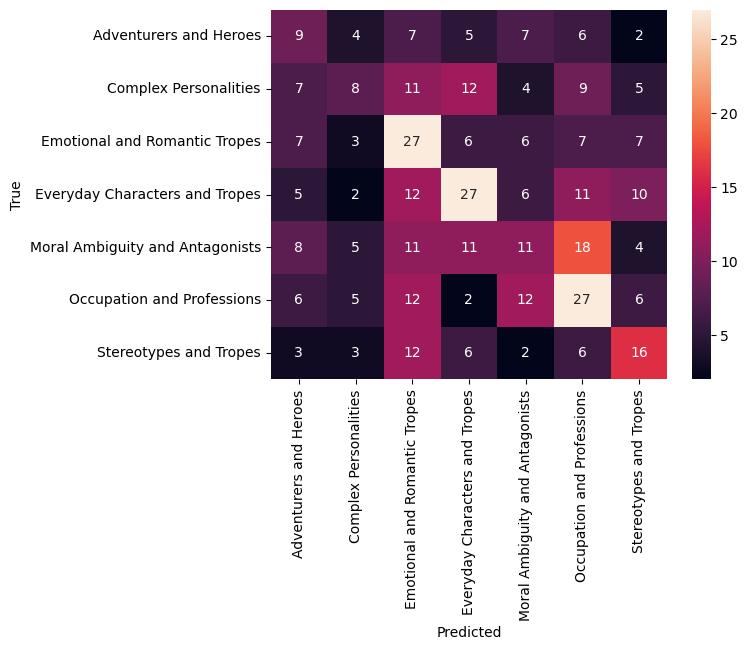

In [26]:
import seaborn as sns
ax = sns.heatmap(cross_tab, annot=True)
ax.set(xlabel="Predicted", ylabel="True")

In [27]:
accuracy_per_class = []

for i in range(len(cross_tab)):
    percentage = cross_tab.iat[i,i] / cross_tab.iloc[i].sum()
    accuracy_per_class.append(percentage)
    print("Accuracy for {} : {:2.2%}".format(cross_tab.index[i], percentage))
    
print("Mean accuracy over all class : {:2.2%}".format(sum(accuracy_per_class)/len(accuracy_per_class)))

Accuracy for Adventurers and Heroes : 22.50%
Accuracy for Complex Personalities : 14.29%
Accuracy for Emotional and Romantic Tropes : 42.86%
Accuracy for Everyday Characters and Tropes : 36.99%
Accuracy for Moral Ambiguity and Antagonists : 16.18%
Accuracy for Occupation and Professions : 38.57%
Accuracy for Stereotypes and Tropes : 33.33%
Mean accuracy over all class : 29.24%


### Test : weightings + 5NN

In [28]:
def predict_type_v3(unlabeled_entry, labeled_entries):
    
    # We keep the 5 closest neighboors + Weightings
    labeled_entries.reset_index(inplace=True,drop=True)
    votes_on_type = {'Adventurers and Heroes':0,'Complex Personalities':0,'Emotional and Romantic Tropes':0,
              'Everyday Characters and Tropes':0,'Moral Ambiguity and Antagonists':0,'Occupation and Professions':0,
              'Stereotypes and Tropes':0}
    
    for sent in unlabeled_entry['related_embeddings']:
        max_val_1 = -11 # Smaller than max_val_2
        max_val_2 = -10 # Smaller than max_val_3
        max_val_3 = -9 # Smaller than max_val_4
        max_val_4 = -8 # Smaller than max_val_5
        max_val_5 = -7
        # We keep this order between the three highest values at each instant
        for i in range(len(labeled_entries)): 
            labeled_sent = labeled_entries.at[i, 'related_embeddings']
            for s in labeled_sent:
                val = np.dot(sent,s)/(np.linalg.norm(sent)*np.linalg.norm(s))
                if val > max_val_5:
                    # val is greater than all five highest values
                    max_val_5 = val
                    max_type_5 = labeled_entries.at[i, 'MainCharType']
                elif val > max_val_4:
                    # val is smaller than max_val_5 but greater than max_val_4
                    max_val_4 = val
                    max_type_4 = labeled_entries.at[i, 'MainCharType']
                elif val > max_val_3:
                    # Same logic
                    max_val_3 = val
                    max_type_3 = labeled_entries.at[i, 'MainCharType']
                elif val > max_val_2:
                    # Same logic
                    max_val_2 = val
                    max_type_2 = labeled_entries.at[i, 'MainCharType']
                elif val > max_val_1:
                    # Same logic
                    max_val_1= val
                    max_type_1 = labeled_entries.at[i, 'MainCharType']
        votes_on_type[max_type_1] += weights[max_type_1] * max_val_1
        votes_on_type[max_type_2] += weights[max_type_2] * max_val_2
        votes_on_type[max_type_3] += weights[max_type_3] * max_val_3
        votes_on_type[max_type_4] += weights[max_type_4] * max_val_4
        votes_on_type[max_type_5] += weights[max_type_5] * max_val_5
    # Get the MainCharType with highest value
    mainchartype = max(votes_on_type, key=votes_on_type.get)
    
    return(mainchartype)

In [29]:
correct_predictions = 0

# To understand the distribution of errors
cross_tab = pd.DataFrame(index=char_types, columns=char_types).fillna(0)

for i,character in tqdm(labeled.iterrows(), total=labeled.shape[0]):
    tmp_labeled = labeled.drop(index=i)
    prediction = predict_type_v3(character, tmp_labeled)
    correct_predictions += int(prediction == character['MainCharType'])
    cross_tab.at[character['MainCharType'], prediction] += 1
    
print("Accuracy of the model is {:2.2%}".format(correct_predictions / len(labeled)))

100%|████████████████████████████████████████████████████████████████████████████████| 418/418 [04:22<00:00,  1.60it/s]

Accuracy of the model is 30.62%


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.7222222222222, 0.5, 'True')]

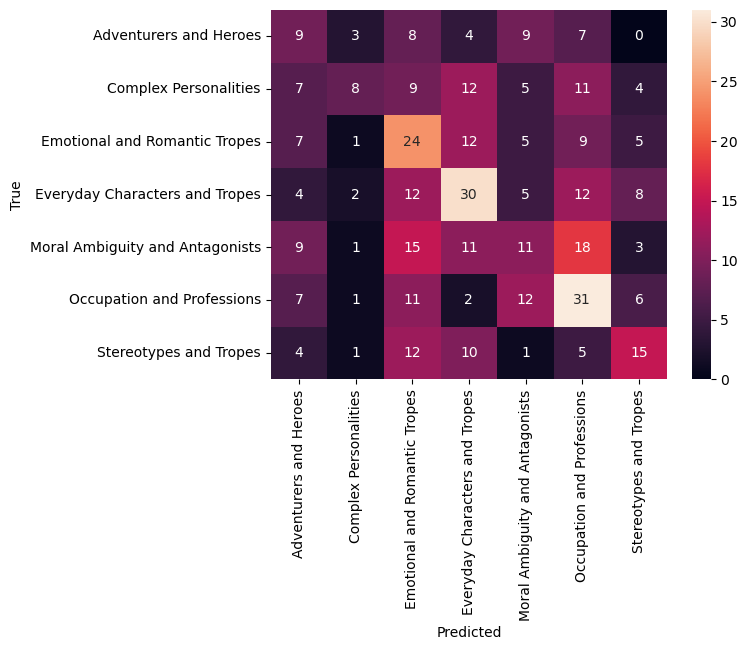

In [30]:
import seaborn as sns
ax = sns.heatmap(cross_tab, annot=True)
ax.set(xlabel="Predicted", ylabel="True")

In [31]:
accuracy_per_class = []

for i in range(len(cross_tab)):
    percentage = cross_tab.iat[i,i] / cross_tab.iloc[i].sum()
    accuracy_per_class.append(percentage)
    print("Accuracy for {} : {:2.2%}".format(cross_tab.index[i], percentage))
    
print("Mean accuracy over all class : {:2.2%}".format(sum(accuracy_per_class)/len(accuracy_per_class)))

Accuracy for Adventurers and Heroes : 22.50%
Accuracy for Complex Personalities : 14.29%
Accuracy for Emotional and Romantic Tropes : 38.10%
Accuracy for Everyday Characters and Tropes : 41.10%
Accuracy for Moral Ambiguity and Antagonists : 16.18%
Accuracy for Occupation and Professions : 44.29%
Accuracy for Stereotypes and Tropes : 31.25%
Mean accuracy over all class : 29.67%


----

In [55]:
def predict_type_v4(unlabeled_entry, labeled_entries):
    
    # We keep the 5 closest neighboors + Weightings + Emphasis on first sentence (often an introduction to the character)
    labeled_entries.reset_index(inplace=True,drop=True)
    votes_on_type = {'Adventurers and Heroes':0,'Complex Personalities':0,'Emotional and Romantic Tropes':0,
              'Everyday Characters and Tropes':0,'Moral Ambiguity and Antagonists':0,'Occupation and Professions':0,
              'Stereotypes and Tropes':0}
    boost = 10
    
    for index_sent ,sent in enumerate(unlabeled_entry['related_embeddings']):
        max_val_1 = -11 # Smaller than max_val_2
        max_val_2 = -10 # Smaller than max_val_3
        max_val_3 = -9 # Smaller than max_val_4
        max_val_4 = -8 # Smaller than max_val_5
        max_val_5 = -7
        # We keep this order between the three highest values at each instant
        for i in range(len(labeled_entries)): 
            labeled_sent = labeled_entries.at[i, 'related_embeddings']
            for s in labeled_sent:
                val = np.dot(sent,s)/(np.linalg.norm(sent)*np.linalg.norm(s))
                if val > max_val_5:
                    # val is greater than all five highest values
                    max_val_5 = val
                    max_type_5 = labeled_entries.at[i, 'MainCharType']
                elif val > max_val_4:
                    # val is smaller than max_val_5 but greater than max_val_4
                    max_val_4 = val
                    max_type_4 = labeled_entries.at[i, 'MainCharType']
                elif val > max_val_3:
                    # Same logic
                    max_val_3 = val
                    max_type_3 = labeled_entries.at[i, 'MainCharType']
                elif val > max_val_2:
                    # Same logic
                    max_val_2 = val
                    max_type_2 = labeled_entries.at[i, 'MainCharType']
                elif val > max_val_1:
                    # Same logic
                    max_val_1= val
                    max_type_1 = labeled_entries.at[i, 'MainCharType']
        if index_sent != 0:
            boost = 1
        votes_on_type[max_type_1] += boost * weights[max_type_1] * max_val_1
        votes_on_type[max_type_2] += boost * weights[max_type_2] * max_val_2
        votes_on_type[max_type_3] += boost * weights[max_type_3] * max_val_3
        votes_on_type[max_type_4] += boost * weights[max_type_4] * max_val_4
        votes_on_type[max_type_5] += boost * weights[max_type_5] * max_val_5
    # Get the MainCharType with highest value
    mainchartype = max(votes_on_type, key=votes_on_type.get)
    
    return(mainchartype)

In [56]:
correct_predictions = 0

# To understand the distribution of errors
cross_tab = pd.DataFrame(index=char_types, columns=char_types).fillna(0)

for i,character in tqdm(labeled.iterrows(), total=labeled.shape[0]):
    tmp_labeled = labeled.drop(index=i)
    prediction = predict_type_v4(character, tmp_labeled)
    correct_predictions += int(prediction == character['MainCharType'])
    cross_tab.at[character['MainCharType'], prediction] += 1
    
print("Accuracy of the model is {:2.2%}".format(correct_predictions / len(labeled)))

100%|████████████████████████████████████████████████████████████████████████████████| 418/418 [03:45<00:00,  1.86it/s]

Accuracy of the model is 30.38%


[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.7222222222222, 0.5, 'True')]

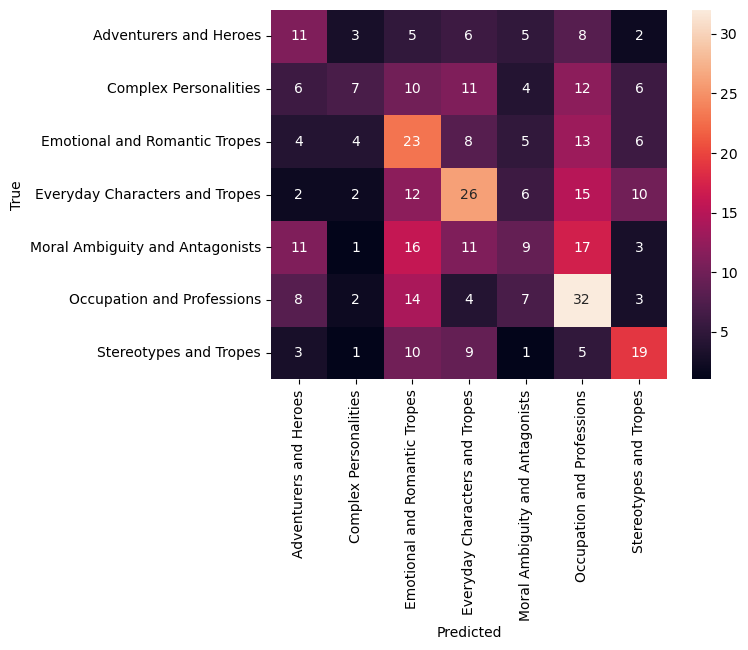

In [57]:
import seaborn as sns
ax = sns.heatmap(cross_tab, annot=True)
ax.set(xlabel="Predicted", ylabel="True")

In [58]:
accuracy_per_class = []

for i in range(len(cross_tab)):
    percentage = cross_tab.iat[i,i] / cross_tab.iloc[i].sum()
    accuracy_per_class.append(percentage)
    print("Accuracy for {} : {:2.2%}".format(cross_tab.index[i], percentage))
    
print("Mean accuracy over all class : {:2.2%}".format(sum(accuracy_per_class)/len(accuracy_per_class)))

Accuracy for Adventurers and Heroes : 27.50%
Accuracy for Complex Personalities : 12.50%
Accuracy for Emotional and Romantic Tropes : 36.51%
Accuracy for Everyday Characters and Tropes : 35.62%
Accuracy for Moral Ambiguity and Antagonists : 13.24%
Accuracy for Occupation and Professions : 45.71%
Accuracy for Stereotypes and Tropes : 39.58%
Mean accuracy over all class : 30.09%


---

Keep the last two models and assess them on test data (the 100 labels given by ChatGPT on new character !)

---

Maybe we should try to assess first the relevance of each sentence in terms of characterization 
Gather a text file with a lot of good characterization sentences. 
Compute the cossim of each of our sentence with this corpus to assess relevance.

-----






Try a whole different method : 
1) normalize all labeled embbedings
2) k-means clustering with k=number of clusters we assume should exist
3) Get the centroids and assign a name to the cluster based on what it contains
4) For each unlabeled point, find the closest centroids + majority votes

### Step 3 : Make predictions on MainCharType for unlabeled characters